D:\Anaconda\lib\site-packages\sklearn\decomposition\_pca.py:642: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


(2430, 31)


D:\Anaconda\lib\site-packages\sklearn\decomposition\_pca.py:642: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


(608, 31)
MSE of Linear Regression: 0.551715391226689
r2_score of Linear Regression: 0.42756293970744697


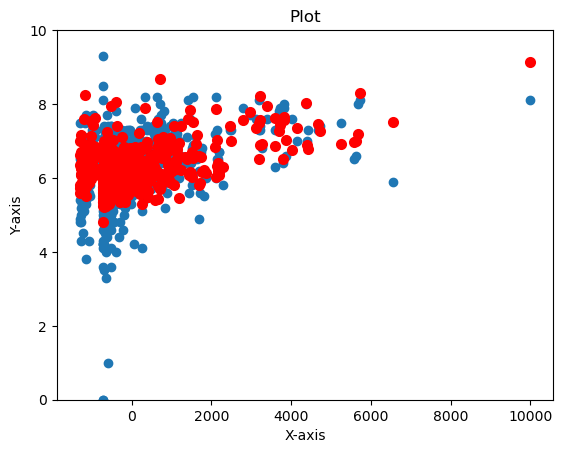

MSE of Polynomial Regression: 0.49526898870410746
r2_score of Polynomial Regression: 0.4861293912473865


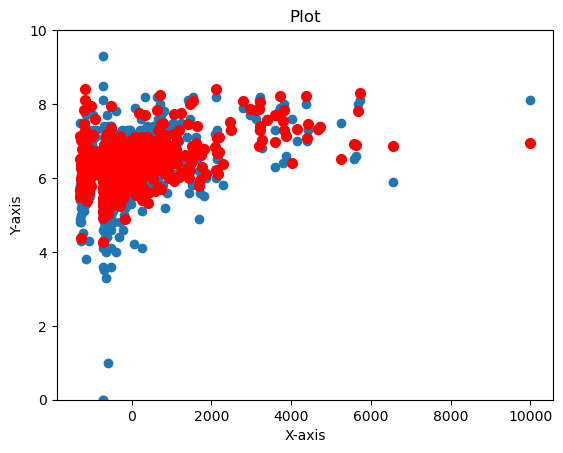

In [12]:
# -*- coding: utf-8 -*-
"""Movie_Milestone1.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1latWBXCOvcK-hvVcKNlwXYw85glOgTLF
"""

from pandas import read_csv, DataFrame
import pandas as pd
import numpy as np
import json
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
import nltk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# from google.colab import drive
# drive.mount('/content/drive')

df = read_csv("movies-regression-dataset.csv")

# Extract Info from columns which contain lists
def parseJson(x, key): # Extract key from data
  listOfJson = json.loads(x)
  return [j.get(key) for j in listOfJson]

# Cleansing
voteAvgMean = df['vote_average'].mean()
meanBudget = 42114757.04578968

origLangEncoder = LabelEncoder()
# origLangEncoder.fit(df['original_language'])
companiesGroups = dict()
prodCountRepet = dict()
langRatings = dict()



cleanDf = df.copy()

cleanDf['production_countries'] = cleanDf['production_countries'].apply(lambda x: parseJson(x, 'iso_3166_1'))
uniqueProdComp = list(set(cleanDf['production_countries'].sum()))
prodCountRepet = { i : 0 for i in uniqueProdComp }

def calcRep(values):
  for value in values:
    prodCountRepet[value] += 1
  return values

cleanDf['production_countries'].apply(lambda x: calcRep(x))


cleanDf['production_companies'] = cleanDf['production_companies'].apply(lambda x: parseJson(x, 'name'))
uniqueVals = list(set(cleanDf['production_companies'].sum())) #get unique values in production companies
badMovies = { i : 0.0001 for i in uniqueVals }
goodMovies = badMovies.copy()
def calcGoodCount(row):
  rate = row['vote_average']
  values = row['production_companies']
  for value in values:
    if(rate > 7):
      goodMovies[value] += 1
    elif(rate < 4):
      badMovies[value] += 1
  return row

cleanDf.apply(lambda x: calcGoodCount(x), axis=1)

for val in uniqueVals:
  ratio = goodMovies[val] / badMovies[val]
  score = 0
  if(ratio >= 1.3):
    group = 1
  elif(ratio <= 0.7):
    group = -1
  else:
    group = 0
  companiesGroups[val] = group


cleanDf['spoken_languages'] = cleanDf['spoken_languages'].apply(lambda x: parseJson(x, 'iso_639_1'))
uniqueLangs = list(set(cleanDf['spoken_languages'].sum()))
langRatings = { i : [] for i in uniqueLangs }
def calcRep(row):
  values = row['spoken_languages']
  rate = row['vote_average']
  for value in values:
    langRatings[value].append(rate)
  return row

cleanDf = cleanDf.apply(lambda x: calcRep(x), axis=1)
for lang in langRatings:
  rates = langRatings[lang]
  langRatings[lang] = sum(rates) / len(rates)


all_keywords = [item for sublist in cleanDf['keywords'].values for item in sublist]
keywords = nltk.FreqDist(all_keywords)
# Get most frequent tags
frequencies_words = keywords.most_common(25)
tags_features = [word[0] for word in frequencies_words]

#df.isnull().sum()
df = df[df['runtime'].notna()]

statusEncoder = LabelEncoder()
statusEncoder.fit(df['status'])


def save_model(model, filename):
  pickle.dump(model, open(filename + ".pkl", 'wb'))

def load_model(filename):
  return pickle.load(open(filename + ".pkl", 'rb'))

save_model(companiesGroups, 'companiesGroups')
save_model(langRatings, 'langRatings')
save_model(prodCountRepet, 'prodCountRepet')
save_model(origLangEncoder, 'origLangEncoder')
save_model(tags_features, 'tags_features')
save_model(statusEncoder, 'statusEncoder')





def preprocessing(df):

        #load our helping statistics
        companiesGroups = load_model('companiesGroups')
        langRatings = load_model('langRatings')
        prodCountRepet = load_model('prodCountRepet')
        origLangEncoder = load_model('origLangEncoder')
        tags_features = load_model('tags_features')
        statusEncoder = load_model('statusEncoder')
        
        
        df['budget'] = df['budget'].apply(lambda x: meanBudget if x < 1000 else x)
        df['genres'] = df['genres'].apply(lambda x: parseJson(x, 'name'))
        df['keywords'] = df['keywords'].apply(lambda x: parseJson(x, 'name'))
        df['production_companies'] = df['production_companies'].apply(lambda x: parseJson(x, 'name'))
        df['production_countries'] = df['production_countries'].apply(lambda x: parseJson(x, 'iso_3166_1'))
        df['spoken_languages'] = df['spoken_languages'].apply(lambda x: parseJson(x, 'iso_639_1'))

        
        

        # 3- apply one hot encoded on genre 
        def encodeGenres(df):
            colName = 'genres'
            genres = {
                'Drama': 'Drama/Romance',
                'Romance': 'Drama/Romance',
                'Comedy': 'Comedy',
                'Action': 'Action/Adventure',
                'Adventure': 'Action/Adventure',
                'Horror': 'Horror/Thriller',
                'Thriller': 'Horror/Thriller',
                'Science Fiction': 'Science Fiction/Fantasy',
                'Fantasy': 'Science Fiction/Fantasy',
                'Crime': 'Crime/Mystery',
                'Mystery': 'Crime/Mystery',
                'War': 'War/Western',
                'Western': 'War/Western',
                'History': 'History/Documentary',
                'Documentary': 'History/Documentary',
                'Animation': 'Animation/Family',
                'Family': 'Animation/Family',
                'Music': 'Music/TV Movie',
                'TV Movie': 'Music/TV Movie',
                'Foreign': 'Foreign'
              }    
            for genreGroup in genres.values():
                zeroCol = [0] * df.shape[0]
                df[genreGroup] = zeroCol

            def encodeLists(row, colName):
                values = row[colName]
                for value in values:
                    group = genres[value]
                    row[group] = 1
                return row

            df = df.apply(lambda row: encodeLists(row, colName), axis=1)
            df = df.drop(colName, axis=1) # drop column after apply preprocessing on it(on hot encoded)
            return df
        df = encodeGenres(df)


        # 4- keywords
        
        new_df=pd.DataFrame()
        for key in tags_features:
            new_df[key] = df['keywords'].apply(lambda x: int(key in x))
        #print(new_df.shape)
        x = new_df.iloc[:, :].values
        pca = PCA(n_components=1)
        principalComponents = pca.fit_transform(x)
        principalDataframe = pd.DataFrame(data = principalComponents, columns = ['aug_keywords'])
        #print(principalDataframe.shape)
        df=pd.concat([principalDataframe.reset_index(drop=True),df.reset_index(drop=True)],axis=1)
        print(df.shape)

        # 5- make Label encoder to original_language
        df['original_language'] = origLangEncoder.fit_transform(df['original_language'])

        # 6- production Companies
        def encodeProdCompanies(df):
          
            def calcCompanyGroup(companies):
                score = 0
                for company in companies:
                    score += companiesGroups[company] if company in companiesGroups.keys() else 0
                return score  
            df['production_companies'] = df['production_companies'].apply(lambda x: calcCompanyGroup(x))
            df.rename(columns = {'production_companies' : 'prod_comp_weights'}, inplace = True)
            return df
        df = encodeProdCompanies(df)


        # 7- Production countries
        def encodeProdCountries(df):
            def calcWeight(values):
                score = 0
                for value in values:
                    score += prodCountRepet[value] if value in prodCountRepet.keys() else 0
                return score
            
            df['production_countries'] = df['production_countries'].apply(lambda x: calcWeight(x))
            df.rename(columns = {'production_countries' : 'prod_cntries_all_mov'}, inplace = True)

        encodeProdCountries(df)


        # 8-Extract Year from release date
        def toDate(x):
            format = '%m/%d/%Y'
            if('-' in x):
                format = '%m-%d-%Y'
            return datetime.strptime(x, format)

        df['release_date'] = df['release_date'].apply(lambda x: toDate(x))
        df['release_date'] = df['release_date'].dt.year
        df.rename(columns = {'release_date':'release_year'}, inplace = True)

        # 9-spoken Language
        def encodeSpokenLangs(df):
            
            def putAverage(values):
                if(len(values) == 0):
                    return voteAvgMean
                ratingsOfAllLangs = []
                for value in values:
                    if(value in langRatings.keys()):
                        ratingsOfAllLangs.append(langRatings[value])
                return sum(ratingsOfAllLangs) / len(ratingsOfAllLangs)
            

            df['spoken_languages'] = df['spoken_languages'].apply(lambda x: putAverage(x))
            df.rename(columns = {'spoken_languages' : 'spoken_langs_weights'}, inplace = True)
            return df
        df = encodeSpokenLangs(df)


        # 10-make label encoder to status
        df['status'] = statusEncoder.transform(df['status'])
        
        scaler = StandardScaler()
        # Fit and transform the training data
        scaledBud = scaler.fit_transform(np.array(df['budget']).reshape(-1, 1))
        df['budget'] = scaledBud

        #drop columns like home page whichs has 1910 nulls ,id all of its values is unique ,tagline has 383 nulls 
        df = df.drop(columns=['homepage', 'original_title', 'overview', 'tagline', 'title','keywords'], axis=1)

        X = df[['budget', 'prod_comp_weights', 'prod_cntries_all_mov', 'release_year',
       'runtime', 'spoken_langs_weights', 'vote_count', 'Drama/Romance',
       'Comedy', 'Action/Adventure', 'Horror/Thriller', 'Crime/Mystery',
       'War/Western', 'History/Documentary', 'Animation/Family', 'Foreign']]

        if('vote_average' in df.columns):
          def calcWeightedRate(filmRow):
            avgRating = filmRow['vote_average']
            voteCount = filmRow['vote_count']
            m = 10
            C = voteAvgMean
            weighted_rating = (avgRating * voteCount + C * m) / (voteCount + m)
            return weighted_rating

          df['weighted_rate'] = df.apply(lambda row: calcWeightedRate(row), axis=1)
          y = df[['vote_average', 'weighted_rate']]
          return X, y

        return X


TrainDf, TestDf = train_test_split(df, test_size = 0.2, random_state = 0)
X_train, y_train = preprocessing(TrainDf)
y_train = y_train['weighted_rate']

X_test, y_test = preprocessing(TestDf)
y_test = y_test['vote_average']



regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred = np.array(y_pred)
y_test = np.array(y_test)


print("MSE of Linear Regression:",metrics.mean_squared_error(y_test,y_pred))
print("r2_score of Linear Regression:",metrics.r2_score(y_test,y_pred))

pca = PCA(n_components=1)
principalComponents = pca.fit_transform(X_test)

import matplotlib.pyplot as plt
plt.scatter(principalComponents, y_test)
plt.scatter(principalComponents, y_pred, color='red', linewidth = 2)
# Set the plot title and axis labels
plt.title('Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.ylim(0, 10)

# Display the plot
plt.show()


# Polynomial Regression
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
ypred=poly_model.predict(poly_features.transform(X_test))

print('MSE of Polynomial Regression:', metrics.mean_squared_error(y_test, ypred))
print("r2_score of Polynomial Regression:",metrics.r2_score(y_test,ypred))


#plots
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(X_test)
plt.scatter(principalComponents, y_test)
plt.scatter(principalComponents, ypred, color='red', linewidth = 2)
# Set the plot title and axis labels
plt.title('Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.ylim(0, 10)
# Display the plot
plt.show()


save_model(regressor, 'LinearRegression')
save_model(poly_features, 'PolynomialFeatures')
save_model(poly_model, 'PolynomialRegression')




Test Script

In [13]:
test_df = read_csv("movies-tas-test.csv")

# Treating Null Values
test_df['budget'] = test_df['budget'].apply(lambda x: x if not pd.isna(x) else 0)
test_df['genres'] = test_df['genres'].apply(lambda x: x if not pd.isna(x) else '[]')
test_df['keywords'] = test_df['keywords'].apply(lambda x: x if not pd.isna(x) else '[]')
test_df['original_language'] = test_df['original_language'].apply(lambda x: x if not pd.isna(x) else 'en')
test_df['viewercount'] = test_df['viewercount'].apply(lambda x: x if not pd.isna(x) else 0)
test_df['production_companies'] = test_df['production_companies'].apply(lambda x: x if not pd.isna(x) else '[]')
test_df['production_countries'] = test_df['production_countries'].apply(lambda x: x if not pd.isna(x) else '[]')
test_df['release_date'] = test_df['release_date'].apply(lambda x: x if not pd.isna(x) else datetime.today().strftime('%m/%d/%Y'))
test_df['revenue'] = test_df['revenue'].apply(lambda x: x if not pd.isna(x) else 0)
test_df['runtime'] = test_df['runtime'].apply(lambda x: x if not pd.isna(x) else 90)
test_df['spoken_languages'] = test_df['spoken_languages'].apply(lambda x: x if not pd.isna(x) else '[]')
test_df['vote_count'] = test_df['vote_count'].apply(lambda x: x if not pd.isna(x) else 0)
test_df['status'] = test_df['status'].apply(lambda x: x if not pd.isna(x) else 'Released')


X,y = preprocessing(test_df)
# X, y = preprocessing(test_df)
y = y['vote_average']

linearModel = load_model('LinearRegression')
poly_features = load_model('PolynomialFeatures')
poly_model = load_model('PolynomialRegression')

linearPred = linearModel.predict(X)

print("MSE of Linear Regression:",metrics.mean_squared_error(y, linearPred))
print("r2_score of Linear Regression:",metrics.r2_score(y, linearPred))

X_poly = poly_features.transform(X)
polyPred = poly_model.predict(X_poly)

print("MSE of Polynomial Regression:",metrics.mean_squared_error(y, polyPred))
print("r2_score of Polynomial Regression:",metrics.r2_score(y, polyPred))


(380, 31)
MSE of Linear Regression: 0.5369147003010212
r2_score of Linear Regression: 0.36424806320753966
MSE of Polynomial Regression: 1.5557240501535594
r2_score of Polynomial Regression: -0.8421074659442602


D:\Anaconda\lib\site-packages\sklearn\decomposition\_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
